## hand representation
- bit-vector

In [1]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


## Params

In [3]:
_RUN_UNIT_TESTS = True

## Load game constants

In [4]:
from constants import *

## Utils

In [5]:
def binify(bits_list):
    return [bin(b) for b in bits_list]

In [6]:
def run_unit_tests(unit_fn):
    if _RUN_UNIT_TESTS:
        unit_fn()
        print(f"`{unit_fn.__name__}` success!")
    else:
        print(f"Skipping `{unit_fn.__name__}`")


In [7]:
# rating utils
def rank_bits_to_nums(ranks):
    vals = []
    for r in range(NUM_RANKS):
        if (BIT[r] & ranks) > 0:
            vals += [r]
    return tuple(reversed(vals))

def rating_get_type(rating):
    return (rating & RATING_TYPE_MASK) >> (2 * NUM_RANKS)

def rating_get_kicker1(rating):
    return rank_bits_to_nums((rating & RATING_KICKER1_MASK) >> NUM_RANKS)

def rating_get_kicker2(rating):
    return rank_bits_to_nums((rating & RATING_KICKER2_MASK))

def rating_bits_to_tuple(rating):
    return (rating_get_type(rating), rating_get_kicker1(rating), rating_get_kicker2(rating))


_rating_type_to_str = [None, "high card", "pair", "two pair", "three kind", "straight", "flush", "full house", "four kind", "straight flush"]

def rating_prettify(rating):
    (rtype, k1, k2) = rating_bits_to_tuple(rating)
    
    return (_rating_type_to_str[rtype], k1, k2)

In [8]:
def inv_bits(hand):
    return hand ^ ALL_BITS

def rbits_to_bits(rbits):
    return rbits + (rbits << NUM_RANKS) + (rbits << 2 * NUM_RANKS) + (rbits << 3 * NUM_RANKS)

def remove_ranks(hand, rbits):
    """ Removes all ranks in rbits from bits
    bits - original bitvec
    rbits - bit ranks to remove
    """
    keep_bits = inv_bits(rbits_to_bits(rbits))
    return hand & keep_bits

def get_bits_by_suit(hand):
    vals = []
    for s in range(NUM_SUITS):
        vals += [(hand >> (s * NUM_RANKS)) & SUIT_MASK]
    return vals

In [9]:
# returns highest bit (1 << bitind)

def get_n_highest_bits(bits, n):
    v = 0
    for i in range(n):
        b = get_highest_bit(bits)
        bits -= b
        v += b
    return v

def get_highest_bit(bits):
    # ensure it has at least one bit
    if bits == 0:
        return 0
    
#     return BIT[np.ceil(np.log2(bits + 1)).astype(int) - 1]
    return BIT[bits.bit_length() - 1]



In [10]:
# returns bit vector of NUM_RANKS length
def get_1k_ranks(hand):
    bits_by_suit = get_bits_by_suit(hand)
    b1, b2, b3, b4 = bits_by_suit
    return b1 | b2 | b3 | b4
    
#     total = 0
#     for s in range(NUM_SUITS):
#         total = total | (bits >> (s * NUM_RANKS))
#     return total & SUIT_MASK

def get_highest_1k(hand, n=1):
    ranks = get_1k_ranks(hand)
    return get_highest_bit(ranks)

def get_n_highest_1k(hand, n):
    ranks = get_1k_ranks(hand)
    return get_n_highest_bits(ranks, n)



def get_2k_ranks(hand):
    bits_by_suit = get_bits_by_suit(hand)
    b1, b2, b3, b4 = bits_by_suit
    return (b1 & b2) | (b1 & b3) | (b1 & b4) | (b2 & b3) | (b2 & b4) | (b3 & b4)
    
def get_highest_2k(hand):
    ranks = get_2k_ranks(hand)
    return get_highest_bit(ranks)

def get_n_highest_2k(hand, n):
    ranks = get_2k_ranks(hand)
    return get_n_highest_bits(ranks, n)



def get_3k_ranks(bits):
    bits_by_suit = get_bits_by_suit(bits)
    b1, b2, b3, b4 = bits_by_suit
    return (b1 & b2 & b3) | (b1 & b2 & b4) | (b1 & b3 & b4) | (b2 & b3 & b4)
    
def get_highest_3k(hand):
    ranks = get_3k_ranks(hand)
    return get_highest_bit(ranks)

def get_n_highest_3k(hand, n):
    ranks = get_3k_ranks(bits)
    return get_n_highest_bits(ranks, n)



def get_4k_ranks(hand):
    bits_by_suit = get_bits_by_suit(hand)
    b1, b2, b3, b4 = bits_by_suit
    return b1 & b2 & b3 & b4
    
def get_highest_4k(hand):
    ranks = get_4k_ranks(hand)
    return get_highest_bit(ranks)

def get_n_highest_4k(hand, n):
    ranks = get_4k_ranks(hand)
    return get_n_highest_bits(ranks, n)

In [11]:
## cards are a tuple representation of a hand (bit-vector)

def validate_card(s, r):
    assert 0 <= s < NUM_SUITS and 0 <= r < NUM_RANKS

def validate_cards(cards):
    assert len(set(cards)) == len(cards) # ensure cards are unique
    for s, r in cards:
        validate_card(s, r)

def validate_ind(ind):
    assert 0 <= ind < NUM_CARDS

def card_to_ind(s, r):
    validate_card(s, r)
    return s * NUM_RANKS + r

def ind_to_card(ind):
    validate_ind(ind)
    return (ind // NUM_RANKS, ind % NUM_RANKS)

def hand_to_cards(hand):
    assert 0 <= hand < (1 << NUM_CARDS)
    
    cards = []
    for ind, card in enumerate(CARDS):
        if (hand & BIT[ind]) > 0:
            cards += [card]
            
    return cards

def cards_to_hand(cards):
    validate_cards(cards)
    
    hand = 0
    for s, r in cards:
        hand += BIT[card_to_ind(s, r)]
    return hand

            
def unit_tests__card_to_ind():
    assert ( card_to_ind(0, 0) == 0 )
    assert ( card_to_ind(0, 1) == 1 )
    assert ( card_to_ind(1, 1) == 14 )
    assert ( card_to_ind(2, 6) == 32 )
    assert ( card_to_ind(3, 12) == 51 )
    
def unit_tests__ind_to_card():
    assert ( ind_to_card(0) == (0, 0) )
    assert ( ind_to_card(5) == (0, 5) )
    assert ( ind_to_card(13) == (1, 0) )
    assert ( ind_to_card(51) == (3, 12) )
    

def unit_tests__hand_to_cards():
    assert ( tuple(hand_to_cards(0b11)) == ((0, 0), (0, 1)) )
    assert ( tuple(hand_to_cards((1 << 13) + 7)) == ((0, 0), (0, 1), (0, 2), (1, 0)) )
    assert ( tuple(hand_to_cards((3 << 13) + 7)) == ((0, 0), (0, 1), (0, 2), (1, 0), (1, 1)) )


run_unit_tests(unit_tests__card_to_ind)
run_unit_tests(unit_tests__ind_to_card)
run_unit_tests(unit_tests__hand_to_cards)
    

`unit_tests__card_to_ind` success!
`unit_tests__ind_to_card` success!
`unit_tests__hand_to_cards` success!


## ratings

- straight flush (SF)
    - highest value (1 number, 13 bits)

- four of a kind (4K)
    - four + kicker (1 +  numbers, 13 bits)

- full house (FH)
    - triple + pair (1 + 1 numbers, 26 bits)

- flush (FL)
    - highest five numbers (5 numbers, 13 bits)
  
- straght (ST)
    - highest value 1 number, 13 bits)

- triple (3K)
    - triple + kicker1 + kicker2 (1 + 2 highest numbers, 26 bits)
    
- two pair (2P)
    - pair1 + pair2 + kicker (2 + 1 highest number, 26 bits)

- pair (2K)
    - pair + kicker1 + kicker2 + kicker3 (1 + 3 highest numbers, 13 bits)

- high card (1K)
    - highest five numbers (5 nums, 13 bits)

In [51]:
# check for a straight flush
# base_mask = (1 << STRAIGHT_FLUSH_LEN) - 1
# _sf_masks = [base_mask << (r + s * NUM_RANKS) for r in range(NUM_RANKS - STRAIGHT_FLUSH_LEN + 1) for s in range(NUM_SUITS)]

# use same base mask as _sf_masks
wheel_mask = (1 << (NUM_RANKS - 1)) + (1 << (STRAIGHT_LEN - 1)) - 1
base_mask = (1 << STRAIGHT_LEN) - 1
_straight_masks = [wheel_mask] + [base_mask << r for r in range(NUM_RANKS - STRAIGHT_LEN + 1)]

In [52]:
def check_straight_flush(hand):
    bits_by_suit = get_bits_by_suit(hand)
    
    rating = 0
    
    for mask in _straight_masks:
        for ranks in bits_by_suit:
            masked = ranks & mask
            if masked.bit_count() == STRAIGHT_FLUSH_LEN:
                rating = masked
                
    
    if rating > 0:
        if rating == wheel_mask:
            rating = wheel_mask - get_highest_bit(wheel_mask)
            
        return STRAIGHT_FLUSH_RATING + rating
    else:
        return 0
    
    
#     is_sf_mask = (1 << STRAIGHT_FLUSH_LEN) - 1

#     rating = 0

#     # since this goes from small to big, we can use `rating = val`
#     for mask in _sf_masks:
#         masked = mask & n
        
#         ind = (mask.bit_length() - 1) // NUM_RANKS * NUM_RANKS
        
#         if masked.bit_count() == STRAIGHT_FLUSH_LEN:
#             rating = masked >> ind

#     if rating > 0:
#         return STRAIGHT_FLUSH_RATING + rating
#     else:
#         return 0
    
def unit_tests__check_straight_flush():
    # wheel tests
    assert check_straight_flush(0b1000000001111) == STRAIGHT_FLUSH_RATING + 0b0000000001111
    assert check_straight_flush(0b1000000001111 << 13) == STRAIGHT_FLUSH_RATING + 0b0000000001111
    assert check_straight_flush(0b1000000001111 << 26) == STRAIGHT_FLUSH_RATING + 0b0000000001111
    assert check_straight_flush(0b1111) == 0
    assert check_straight_flush(0b1100000000111) == 0
    
    assert check_straight_flush(0b11111) == STRAIGHT_FLUSH_RATING + 0b11111
    assert check_straight_flush(0b11111 << 13) == STRAIGHT_FLUSH_RATING + 0b11111
    assert check_straight_flush(0b11111 << 12) == 0
    assert check_straight_flush(0b11111 << 9) == 0
    assert check_straight_flush(0b11111 << 8) == STRAIGHT_FLUSH_RATING + (0b11111 << 8)
    assert check_straight_flush(0b11111 << 39) == STRAIGHT_FLUSH_RATING + (0b11111)
    assert check_straight_flush(0b11111 << 47) == STRAIGHT_FLUSH_RATING + (0b11111 << 8)
    
    assert check_straight_flush(0b1111111) == STRAIGHT_FLUSH_RATING + (0b11111 << 2)
    assert check_straight_flush(0b111111 << 8) == STRAIGHT_FLUSH_RATING + (0b11111 << 8)
    assert check_straight_flush(0b11111 << 12) == 0
    assert check_straight_flush(0b111111 << 12) == STRAIGHT_FLUSH_RATING + (0b11111)
    

    
run_unit_tests(unit_tests__check_straight_flush)

`unit_tests__check_straight_flush` success!


In [53]:
def check_four_kind(bits):

    fours = get_highest_4k(bits)

    if fours > 0:
        # find kicker
        bits = remove_ranks(bits, fours)
        kicker = get_highest_1k(bits)

        return FOUR_KIND_RATING + (fours << NUM_RANKS) + kicker
    else:
        return 0
    
def unit_tests__check_four_kind():

    base_bits = (1 << 0) + (1 << 13) + (1 << 26) + (1 << 39)

    bits = base_bits + (base_bits << 10) + (1 << 3)
    ans = FOUR_KIND_RATING + (1 << 10 << NUM_RANKS) + (1 << 3)
    assert check_four_kind(bits) == ans
    
    bits = (base_bits - 1)
    ans = 0
    assert check_four_kind(bits) == ans

    bits = (base_bits << 5) + (base_bits << 10) + (1 << 3)
    ans = FOUR_KIND_RATING + (1 << 10 << NUM_RANKS) + (1 << 5)
    assert check_four_kind(bits) == ans
    
    bits = (1 << NUM_CARDS) - 1
    ans = FOUR_KIND_RATING + (1 << (NUM_RANKS - 1) << NUM_RANKS) + (1 << (NUM_RANKS - 2))
    assert check_four_kind(bits) == ans
    
    bits = (1 << NUM_CARDS) - 1
    ans = FOUR_KIND_RATING + (1 << (NUM_RANKS - 1) << NUM_RANKS) + (1 << (NUM_RANKS - 2))
    assert check_four_kind(bits) == ans
    
run_unit_tests(unit_tests__check_four_kind)

`unit_tests__check_four_kind` success!


In [54]:
def check_full_house(bits):
    triple = get_highest_3k(bits)
    if triple > 0:
        bits = remove_ranks(bits, triple)
        double = get_highest_2k(bits)
        if double > 0:
            return FULL_HOUSE_RATING + (triple << NUM_RANKS) + double
    
    return 0


def unit_tests__check_full_house():

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2)])
    ans = FULL_HOUSE_RATING + (1 << 1 << NUM_RANKS) + (1 << 2)
    print(rating_bits_to_tuple(check_full_house(bits)))
    assert check_full_house(bits) == ans

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (2, 2)])
    ans = FULL_HOUSE_RATING + (1 << 2 << NUM_RANKS) + (1 << 1)
    print(rating_bits_to_tuple(check_full_house(bits)))
    assert check_full_house(bits) == ans

    bits = cards_to_hand([(0, 1), (1, 1), (0, 2), (1, 2)])
    ans = 0
    print(rating_bits_to_tuple(check_full_house(bits)))
    assert check_full_house(bits) == ans
    
    
run_unit_tests(unit_tests__check_full_house)

(7, (1,), (2,))
(7, (2,), (1,))
(0, (), ())
`unit_tests__check_full_house` success!


In [55]:
def check_flush(bits):
    bits_by_suit = get_bits_by_suit(bits)
    
    rating = 0
    for rbits in bits_by_suit:
        masked = get_n_highest_bits(rbits, n=5)
        if masked.bit_count() == FLUSH_LEN:
            rating = max(rating, masked)

    if rating > 0:
        return FLUSH_RATING + rating
    else:
        return 0

    
def unit_tests__check_flush():

    bits = cards_to_hand([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 6), (0, 7)])
    ans = FLUSH_RATING + (0b10111100)
    val = check_flush(bits)
    assert val == ans

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (0, 5), (0, 7), (0, 9), (3, 11)])
    ans = FLUSH_RATING + BIT[1] + BIT[2] + BIT[5] + BIT[7] + BIT[9]
    val = check_flush(bits)
    assert val == ans

    bits = cards_to_hand([(3, 0), (0, 1), (1, 2), (2, 3), (3, 4)])
    ans = 0
    val = check_flush(bits)
    assert val == ans

    bits = cards_to_hand([(3, 0), (0, 1), (1, 2), (2, 3), (3, 4), (3, 8), (0, 9), (1, 10), (2, 11), (3, 12)])
    ans = 0
    val = check_flush(bits)
    assert val == ans

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (2, 2), (0, 10)])
    ans = 0
    val = check_flush(bits)
    assert val == ans

    bits = cards_to_hand([(0, 1), (1, 1), (0, 2), (1, 2)])
    ans = 0
    val = check_flush(bits)
    assert val == ans
    

run_unit_tests(unit_tests__check_flush)

`unit_tests__check_flush` success!


In [56]:
def check_straight(bits):
    rbits = get_1k_ranks(bits)
    
    rating = 0
    
    # since this goes from small to big, we can use `rating = val`
    for mask in _straight_masks:
        masked = rbits & mask
        if masked.bit_count() == STRAIGHT_LEN:
            rating = masked

    if rating > 0:
        return STRAIGHT_RATING + rating
    else:
        return 0

    
def unit_tests__check_straight():

    bits = cards_to_hand([(0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (1, 6), (0, 7)])
    ans = STRAIGHT_RATING + (0b11111 << 3)
    val = check_straight(bits)
    assert val == ans

    bits = cards_to_hand([(3, 0), (0, 1), (1, 2), (2, 3), (3, 4)])
    ans = STRAIGHT_RATING + (0b11111 << 0)
    val = check_straight(bits)
    assert val == ans

    bits = cards_to_hand([(3, 0), (0, 1), (1, 2), (2, 3), (3, 4), (3, 8), (0, 9), (1, 10), (2, 11), (3, 12)])
    ans = STRAIGHT_RATING + (0b11111 << 8)
    val = check_straight(bits)
    assert val == ans

    

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (0, 5), (0, 7), (0, 9), (3, 11)])
    ans = 0
    val = check_straight(bits)
    assert val == ans

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (2, 2), (0, 10)])
    ans = 0
    val = check_straight(bits)
    assert val == ans

    bits = cards_to_hand([(0, 1), (1, 1), (0, 2), (1, 2)])
    ans = 0
    val = check_straight(bits)
    assert val == ans
    

run_unit_tests(unit_tests__check_straight)

`unit_tests__check_straight` success!


In [57]:
def check_three_kind(bits):
    triple = get_highest_3k(bits)
    if triple > 0:
        bits = remove_ranks(bits, triple)
        kickers = get_n_highest_1k(bits, n=2)
        return THREE_KIND_RATING + (triple << NUM_RANKS) + kickers
    
    return 0


def unit_tests__check_three_kind():

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (0, 5)])
    ans = THREE_KIND_RATING + (1 << 1 << NUM_RANKS) + (1 << 2) + (1 << 5)
#     print(rating_bits_to_tuple(check_three_kind(bits)))
    assert check_three_kind(bits) == ans

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (2, 2), (0, 10)])
    ans = THREE_KIND_RATING + (1 << 2 << NUM_RANKS) + (1 << 1) + (1 << 10)
#     print(rating_bits_to_tuple(check_three_kind(bits)))
    assert check_three_kind(bits) == ans

    bits = cards_to_hand([(0, 1), (1, 1), (0, 2), (1, 2)])
    ans = 0
#     print(rating_bits_to_tuple(check_three_kind(bits)))
    assert check_three_kind(bits) == ans
    

run_unit_tests(unit_tests__check_three_kind)

`unit_tests__check_three_kind` success!


In [58]:
def check_two_pair(bits):
    doubles = get_n_highest_2k(bits, n=2)
    if doubles.bit_count() >= 2:
        bits = remove_ranks(bits, doubles)
        kickers = get_highest_1k(bits)
        return TWO_PAIR_RATING + (doubles << NUM_RANKS) + kickers
    
    return 0


def unit_tests__check_two_pair():

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (0, 5)])
    ans = TWO_PAIR_RATING + ((BIT[2] + BIT[1]) << NUM_RANKS) + BIT[5]
    print(rating_bits_to_tuple(check_two_pair(bits)))
    assert check_two_pair(bits) == ans

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (0, 5), (0, 7), (0, 9)])
    ans = TWO_PAIR_RATING + ((BIT[2] + BIT[1]) << NUM_RANKS) + BIT[9]
    print(rating_bits_to_tuple(check_two_pair(bits)))
    assert check_two_pair(bits) == ans

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (2, 2), (0, 10)])
    ans = TWO_PAIR_RATING + ((BIT[2] + BIT[1]) << NUM_RANKS) + BIT[10]
    print(rating_bits_to_tuple(check_two_pair(bits)))
    assert check_two_pair(bits) == ans

    bits = cards_to_hand([(0, 1), (1, 1), (0, 2), (1, 2)])
    ans = TWO_PAIR_RATING + ((BIT[2] + BIT[1]) << NUM_RANKS)
    print(rating_bits_to_tuple(check_two_pair(bits)))
    assert check_two_pair(bits) == ans

    bits = cards_to_hand([(0, 1), (1, 2)])
    ans = 0
    print(rating_bits_to_tuple(check_two_pair(bits)))
    assert check_two_pair(bits) == ans
    

run_unit_tests(unit_tests__check_two_pair)

(3, (2, 1), (5,))
(3, (2, 1), (9,))
(3, (2, 1), (10,))
(3, (2, 1), ())
(0, (), ())
`unit_tests__check_two_pair` success!


In [59]:
def check_two_kind(bits):
    double = get_highest_2k(bits)
    if double > 0:
        bits = remove_ranks(bits, double)
        kickers = get_n_highest_1k(bits, n=3)
        return TWO_KIND_RATING + (double << NUM_RANKS) + kickers
    
    return 0


def unit_tests__check_two_kind():
    
    # 138563026948
    
    bits = cards_to_hand([(0, 2), (1, 11), (1, 12), (2, 4), (2, 11)])
    ans = TWO_KIND_RATING + (1 << 11 << NUM_RANKS) + (1 << 2) + (1 << 4) + (1 << 12)
    print(bits)
    print(rating_bits_to_tuple(check_two_kind(bits)))
    assert check_two_kind(bits) == ans
    
    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (0, 5)])
    ans = TWO_KIND_RATING + (1 << 2 << NUM_RANKS) + (1 << 1) + (1 << 5)
#     print(rating_bits_to_tuple(check_two_kind(bits)))
    assert check_two_kind(bits) == ans

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (0, 5), (0, 7), (0, 9)])
    ans = TWO_KIND_RATING + (1 << 2 << NUM_RANKS) + (1 << 9) + (1 << 7) + (1 << 5)
#     print(rating_bits_to_tuple(check_two_kind(bits)))
    assert check_two_kind(bits) == ans

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (2, 2), (0, 10)])
    ans = TWO_KIND_RATING + (1 << 2 << NUM_RANKS) + (1 << 1) + (1 << 10)
#     print(rating_bits_to_tuple(check_two_kind(bits)))
    assert check_two_kind(bits) == ans

    bits = cards_to_hand([(0, 1), (1, 1), (0, 2), (1, 2)])
    ans = TWO_KIND_RATING + (1 << 2 << NUM_RANKS) + (1 << 1)
#     print(rating_bits_to_tuple(check_two_kind(bits)))
    assert check_two_kind(bits) == ans

    bits = cards_to_hand([(0, 1), (1, 2)])
    ans = 0
#     print(rating_bits_to_tuple(check_two_kind(bits)))
    assert check_two_kind(bits) == ans
    

run_unit_tests(unit_tests__check_two_kind)

138563026948
(2, (11,), (12, 4, 2))
`unit_tests__check_two_kind` success!


In [60]:
def check_one_kind(bits):
    kickers = get_n_highest_1k(bits, n=5)
    return ONE_KIND_RATING + kickers

def unit_tests__check_one_kind():

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (0, 5)])
    ans = ONE_KIND_RATING + BIT[1] + BIT[2] + BIT[5]
    val = check_one_kind(bits)
    assert val == ans

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (0, 5), (0, 7), (0, 9)])
    ans = ONE_KIND_RATING + BIT[1] + BIT[2] + BIT[5] + BIT[7] + BIT[9]
    val = check_one_kind(bits)
    assert val == ans

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (0, 5), (0, 7), (0, 9), (3, 11)])
    ans = ONE_KIND_RATING + BIT[2] + BIT[5] + BIT[7] + BIT[9] + BIT[11]
    val = check_one_kind(bits)
    assert val == ans

    bits = cards_to_hand([(0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (2, 2), (0, 10)])
    ans = ONE_KIND_RATING + BIT[1] + BIT[2] + BIT[10]
    val = check_one_kind(bits)
    assert val == ans

    bits = cards_to_hand([(0, 1), (1, 1), (0, 2), (1, 2)])
    ans = ONE_KIND_RATING + BIT[1] + BIT[2]
    val = check_one_kind(bits)
    assert val == ans

    bits = cards_to_hand([(0, 1), (1, 2)])
    ans = ONE_KIND_RATING + BIT[1] + BIT[2]
    val = check_one_kind(bits)
    assert val == ans

    bits = cards_to_hand([])
    ans = ONE_KIND_RATING
    val = check_one_kind(bits)
    assert val == ans
    

run_unit_tests(unit_tests__check_one_kind)

`unit_tests__check_one_kind` success!


In [61]:
_calls__get_rating = 0
_time__get_rating = 0

def get_rating(hand):
    global _calls__get_rating, _time__get_rating
    _calls__get_rating += 1
    st = time.process_time()
    
    while True:
        val = check_straight_flush(hand)
        if val > 0:
            break
            
        val = check_four_kind(hand)
        if val > 0:
            break
            
        val = check_full_house(hand)
        if val > 0:
            break
            
        val = check_flush(hand)
        if val > 0:
            break
            
        val = check_straight(hand)
        if val > 0:
            break
            
        val = check_three_kind(hand)
        if val > 0:
            break
            
        val = check_two_pair(hand)
        if val > 0:
            break
            
        val = check_two_kind(hand)
        if val > 0:
            break
            
        val = check_one_kind(hand)
        break

    _time__get_rating += time.process_time() - st
    return val
        
def get_hand_rtype(hand):
    rating = get_rating(hand)
    return rating_get_type(rating)
    

## Calculate potential of hands

In [138]:
# returns the maximum potential rating that a player hand could get
_potential_fname = "../data/potential.json"
_rating5_fname = "../data/rating5.json"

In [136]:
def calc_potential_dict():
    potential_dict = dict()
    rating_dict = dict()
    
    rating_dict[0] = get_rating(0)

    for c1 in range(NUM_CARDS):
        b1 = BIT[c1]
        t1 = b1
        rating_dict[t1] = get_rating(t1)
        
        for c2 in range(c1):
            b2 = BIT[c2]
            t2 = t1 + b2
            rating_dict[t2] = get_rating(t2)
            
            for c3 in range(c2):
                b3 = BIT[c3]
                t3 = t2 + b3
                rating_dict[t3] = get_rating(t3)
                
                for c4 in range(c3):
                    b4 = BIT[c4]
                    t4 = t3 + b4
                    rating_dict[t4] = get_rating(t4)
                    
                    for c5 in range(c4):
                        b5 = BIT[c5]
                        t5 = t4 + b5

                        rating = get_rating(t5)
                        rating_dict[t5] = rating

                        # add it for every combo
                        for on1 in [0, b1]:
                            tt1 = on1
                            for on2 in [0, b2]:
                                tt2 = tt1 + on2
                                for on3 in [0, b3]:
                                    tt3 = tt2 + on3
                                    for on4 in [0, b4]:
                                        tt4 = tt3 + on4
                                        for on5 in [0, b5]:
                                            tt5 = tt4 + on5
                                            
                                            potential_dict[tt5] = max(potential_dict.get(tt5, 0), rating)
                                            
    return rating_dict, potential_dict


In [139]:
# rating5_dict, potential_dict = calc_potential_dict()
# # save potentials
# with open(_potential_fname, "w") as f:
#     json.dump(potential_dict, f)
    
# with open(_rating5_fname, "w") as f:
#     json.dump(rating5_dict, f)
    

In [140]:
# load potentials
with open(_potential_fname, "r") as f:
    potential_dict = json.load(f)
    potential_dict = {int(k): int(v) for k, v in potential_dict.items()}
    
# load ratings
with open(_rating5_fname, "r") as f:
    rating5_dict = json.load(f)
    rating5_dict = {int(k): int(v) for k, v in rating5_dict.items()}
    
# expect 2893164
print(len(potential_dict))
print(len(rating5_dict))


2893164
2893164


In [141]:
# def get_rating_fast(hand):
#     if hand in rating5_dict:
#         return rating5_dict[hand]
    
#     return get_rating(hand)

## testing

In [142]:
# https://www.kaggle.com/datasets/rasvob/uci-poker-hand-dataset
_test_file = "../data/poker-hand-testing.csv"

In [143]:
# read df and rename columns
df = pd.read_csv(_test_file)
df.columns = [f"{c}{i}" for i in range(5) for c in "sr"] + ["rtype"]

# make rtypes 1-indexed
# treat royal flush and straight flush as the same
df["rtype"] += 1
df["rtype"] = np.where(df["rtype"] == (STRAIGHT_FLUSH_RATING >> RATING_TYPE_OFFSET) + 1, df["rtype"] - 1, df["rtype"])

# convert rank 1 -> rank 14
# make all ranks/suits 0 indexed


# create hands
df["hand"] = 0

for i in range(5):
    scol = f"s{i}"
    rcol = f"r{i}"
    ccol = f"c{i}"
    
    df[rcol] = np.where(df[rcol] == 1, 14, df[rcol])
    df[rcol] -= 2
    df[scol] -= 1
    
    df[ccol] = df[scol] * NUM_RANKS + df[rcol]
    
    df["hand"] += 2 ** (df[ccol])
                           
# df["bin_hand"] = df["hand"].apply(bin)

# df = df[["hand", "rtype"]].copy()
df = df.drop_duplicates(subset="hand").reset_index(drop=True)

all_df = df



In [145]:
df = all_df
# df = all_df.iloc[:200000]


# validate our get_hand_rtype
df["pred"] = df["hand"].apply(get_hand_rtype)
df[df["pred"] != df["rtype"]]

,s0,r0,s1,r1,s2,r2,s3,r3,s4,r4,rtype,hand,c0,c1,c2,c3,c4,pred


In [146]:
df

,s0,r0,s1,r1,s2,r2,s3,r3,s4,r4,rtype,hand,c0,c1,c2,c3,c4,pred
0,0,12,0,11,1,2,1,1,0,10,1,56320,12,11,15,14,10,1
1,2,10,2,0,2,9,3,3,1,3,2,4501192900608,36,26,35,42,16,2
2,0,7,3,4,0,2,2,0,2,7,2,8804750065796,7,43,2,26,33,2
3,0,2,2,11,1,11,1,12,2,4,2,138563026948,2,37,24,25,30,2
4,2,8,1,5,0,0,1,9,3,7,1,70385928503297,34,18,0,22,46,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829196,0,10,2,7,2,4,0,1,0,7,2,9663677570,10,33,30,1,7,2
829197,2,5,0,4,3,10,1,12,0,2,1,562952134459412,31,4,49,25,2,1
829198,2,12,0,10,1,7,3,7,1,4,2,70643623265280,38,10,20,46,17,2
829199,2,1,3,3,1,5,0,2,3,1,2,5497692618756,27,42,18,2,40,2


## Game

In [147]:
import copy

In [148]:
# Game parameters
NUM_PLAYER_CARDS = 5
MIN_DEALER_CARDS = 8


In [149]:
def init_deck():
    deck = copy.deepcopy(BIT)
#     deck = [i for i in range(NUM_CARDS)]
    np.random.shuffle(deck)
    return deck


def get_rem_deck(rem_mask):
    deck = []
    for ind in range(NUM_CARDS):
        if BIT[ind] & rem_mask:
            deck += [BIT[ind]]
    
    return deck

def get_random_ask():
    return np.random.randint((1 << NUM_CARDS))

def get_rem_hand(player_hand, dealer_hand):
    return ALL_BITS ^ player_hand ^ dealer_hand


In [150]:
def deal_cards(deck, deck_ind, player_ask, player_hand, dealer_hand):
    ind = deck_ind
    for ind in range(deck_ind, len(deck)):
        card_bit = deck[ind]
        card_val = ind_to_card(np.log2(card_bit).astype(int))
        
        if (card_bit & player_ask) > 0:
            player_hand |= card_bit
            return ind + 1, player_hand, dealer_hand        
        else:
            dealer_hand |= card_bit

        
    return ind, player_hand, dealer_hand


def deal_min_cards(deck, deck_ind, dealer_hand):
    num_extra = max(0, MIN_DEALER_CARDS - dealer_hand.bit_count())
    
    ind = deck_ind
    for ind in range(deck_ind, min(len(deck), deck_ind + num_extra)):
        card_bit = deck[ind]
        card_val = ind_to_card(np.log2(card_bit).astype(int))
        
        dealer_hand |= card_bit

        
    return ind, dealer_hand



In [151]:
def rollout_to_end(deck, deck_ind, player_hand, dealer_hand, player_ask_fn):
    num_iters = NUM_PLAYER_CARDS - player_hand.bit_count()
    
    
    
    for i in range(num_iters):
        player_ask = player_ask_fn(player_hand, dealer_hand)
        
        deck_ind, player_hand, dealer_hand = deal_cards(deck, deck_ind, player_ask, player_hand, dealer_hand)
        
        
    deck_ind, dealer_hand = deal_min_cards(deck, deck_ind, dealer_hand)
    
    return player_hand, dealer_hand

In [152]:
def rollout_one(player_hand, dealer_hand, use_mask, skip_mask, trials):
    # always apply these two masks
    # use mask is always |
    # skip_mask is always &
    
    assert player_hand.bit_count() == NUM_PLAYER_CARDS - 1
    
    # setup deck
    rem_mask = get_rem_hand(player_hand, dealer_hand)
    deck = get_rem_deck(rem_mask)
    
    # setup ask fn
    player_ask = (get_random_ask() & skip_mask) | use_mask
    def ask_fn(player_hand, dealer_hand):
        return player_ask
    
    # run trials
    wins = 0
    for t in range(trials):
        # shuffle the deck
        np.random.shuffle(deck)
        
        player_hand, dealer_hand = rollout_to_end(
            deck=deck,
            deck_ind=0,
            player_hand=player_hand,
            dealer_hand=dealer_hand,
            player_ask_fn=ask_fn,
        )
        
        # compare player_hand, dealer_hand
        player_rating = rating5_dict[player_hand]
        dealer_rating = get_rating(dealer_hand)
        
        if player_rating > dealer_rating:
            wins += 1
    
    return wins / trials


In [157]:
def get_player_ask(player_hand, dealer_hand):
        
    use_mask = 0
    skip_mask = ALL_BITS
    
    # get dealer rating
    dealer_rating = get_rating(dealer_hand)

    # check if we have any chance of winning
    # if we don't, take any card
    orig_player_potential = potential_dict[player_hand]
    if orig_player_potential <= dealer_rating: 
        return ALL_BITS

    rem_mask = get_rem_hand(player_hand, dealer_hand)

    for ind in range(NUM_CARDS):
        card_bit = BIT[ind]

        # only test cards that remain
        if rem_mask & card_bit == 0:
            continue

        use1, skip1 = use_mask ^ card_bit, skip_mask
        use2, skip2 = use_mask, skip_mask ^ card_bit

        # see if we definitely do NOT want this card
        player_potential = potential_dict[player_hand + card_bit]
        if player_potential <= dealer_rating:
            use_mask, skip_mask = use2, skip2
            continue

        # see if we definitely WANT this card
#         if player_hand.bit_count() == 4:
#             dealer_potential = get_rating(dealer_hand + card_bit)
#             if orig_player_potential <= dealer_potential:
#                 use_mask, skip_mask = use1, skip1
#                 continue
    
    
    ask = rbits_to_bits(BIT[12] + BIT[11] + BIT[10] + BIT[9] + BIT[8] + BIT[4])
    ask = (ask & skip_mask) | use_mask
    return ask
    

In [158]:
# run a game
def run_game(player_ask_fn):
    deck = init_deck()
    
    # print the deck
#     print([ind_to_card(v) for v in np.log2(deck).astype(int)])

    deck_ind = 0
    player_hand = 0
    dealer_hand = 0

    for i in range(NUM_PLAYER_CARDS):
        player_ask = player_ask_fn(player_hand, dealer_hand)
#         print("phand", hand_to_cards(player_hand))
#         print("dhand", hand_to_cards(dealer_hand))
#         print("player_ask", hand_to_cards(player_ask))
#         print()
        
        
        # iterate cards
        deck_ind, player_hand, dealer_hand = deal_cards(deck, deck_ind, player_ask, player_hand, dealer_hand)
        
    ## add minimum cards
    deck_ind, dealer_hand = deal_min_cards(deck, deck_ind, dealer_hand)

    # calc ratings
    player_rating = rating5_dict[player_hand]
    dealer_rating = get_rating(dealer_hand)
    
    return player_hand, dealer_hand, player_rating, dealer_rating

In [159]:
run_game(get_player_ask)

(562949991171584, 52779243577476, 213913600, 202637376)

In [161]:
start_calls = _calls__get_rating
start_time = _time__get_rating

st = time.process_time()

all_data = []
_num_trials = 10000

for t in range(_num_trials):
    data = run_game(get_player_ask)
#     print("trial", t, data)
    all_data += [data]
    
# create summary df
df = pd.DataFrame(all_data, columns=["phand", "dhand", "prat", "drat"])
df["pwin"] = (df["prat"] > df["drat"]).astype(int)

# print stats
stats = df["pwin"].describe()
std = stats["std"] / np.sqrt(stats["count"])
print("mean", stats["mean"])
print("std", std)
print("95% interval", round(stats["mean"] - 2 * std, 4), round(stats["mean"] + 2 * std, 4))
print()


print("total time", time.process_time() - st)


num_calls = _calls__get_rating - start_calls
num_time = _time__get_rating - start_time
print("get_rating calls", num_calls)
print("get_rating time", num_time)
print("get_rating time per call", num_time / num_calls)


mean 0.3361
std 0.004723971908369089
95% interval 0.3267 0.3455

total time 3.8711299999999937
get_rating calls 60000
get_rating time 1.548025000020516
get_rating time per call 2.58004166670086e-05


In [ ]:
361424

(array([    0.,     0.,     0.,     0.,     0., 10000.,     0.,     0.,
            0.,     0.]),
 array([4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5]),
 <BarContainer object of 10 artists>)

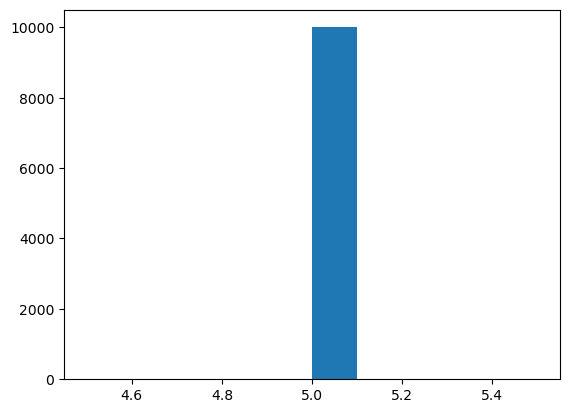

In [45]:
plt.hist(df["phand"].apply(lambda x : x.bit_count()))


In [120]:
x1 = np.array([1])

In [121]:
%%timeit
x1 + x1

474 ns ± 5.33 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [122]:
x2 = np.array([1 for i in range(100)])

In [123]:
%%timeit
x2 + x2

483 ns ± 6.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [124]:
x2 = np.array([1 for i in range(10000)])

In [125]:
%%timeit
x2 + x2

3.28 µs ± 43.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [128]:
x2 = np.array([1 for i in range(100000)])

In [129]:
%%timeit
x2 + x2

31.6 µs ± 336 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [130]:
x2 = np.array([1 for i in range(1000000)])

In [131]:
%%timeit
x2 + x2

1.3 ms ± 38.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
